In [1]:
!python --version

Python 3.12.4


In [2]:
import torch
torch.__version__

'2.7.1+cu118'

In [3]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import torch

from torch import nn
from torchvision import transforms

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
# Setup direcory paths to train and test datasets
train_dir = "flower_dataset/train"
test_dir = "flower_dataset/test"

In [9]:
# Create Datasets and DataLoaders

import os 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 

NUM_WORKERS = os.cpu_count()  # Number of CPU cores available

def create_dataloaders(train_dir: str, test_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int = NUM_WORKERS):
    train_data = datasets.ImageFolder(root=train_dir, transform=transform)
    test_data = datasets.ImageFolder(root=test_dir, transform=transform)

    class_names = train_data.classes

    # Turn images into data loaders 
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, test_loader, class_names

In [10]:
# Create image size
IMG_SIZE = 224  # Common size for ViT models

# Create image transformation pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

print("Manually created transform:", manual_transforms)

Manually created transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [11]:
# Set the batch size
BATCH_SIZE = 32

# Create the DataLoaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x11351c9d9d0>,
 ['dandelion', 'sunflower', 'tulip'])

e:\Programming\AI\ML Files\AI ML\LangChain - Krish Naik\venv1\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([3, 224, 224]) tensor(2)


(-0.5, 223.5, 223.5, -0.5)

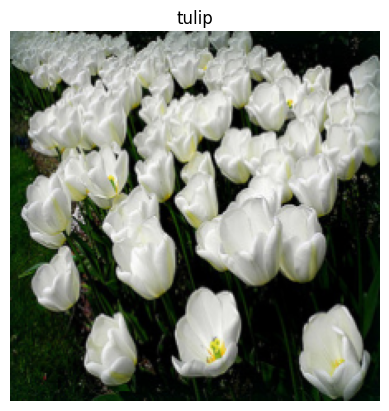

In [12]:
# Get a batch of images 
Image_batch, label_batch = next(iter(train_dataloader))

# Get a single image fromm the batch
image, label = Image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot the image
plt.imshow(image.permute(1, 2, 0))  # rearrange the dimensions to (H, W, C) to suit matplotlib [color_channel, height, width] -> [height, width, color_channel]
plt.title(class_names[label])
plt.axis(False)

# Step-1

Tasks:
1-turn an image into patches 

2-flatten the patch feature maps into a single dimention

3-convert the output into Desired output (flattened 2D patches) -> (196, 768) -> Nx(p2-C) # Current shape: (1, 768, 196)

In [13]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """ 
    Turns a 2D input image into a 1D sequence learning embedding vector.
    This is done by extracting patches from the image and flattening them.

    Args:
        in_channels (int): Number of color input channels in the image (default is 3 for RGB).
        patch_size (int): Size of each patch to be extracted from the image. Default is 16.
        embedding_dim (int): Dimension of the embedding vector for each patch. Default is 768 (16X16X3 = 768).
    """

    # 2. Initialize the class with the required parameters
    def __init__(self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768):
        super().__init__()
        self.patch_size = patch_size  # Store patch_size for use in forward
        
        # 3. Create a convolutional layer to extract patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embedding_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size,
                                    padding=0)

        # 4. Create a layer to turn an image into patches
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)  # Flatten the spatial dimensions (height, width) into a single dimension

    # 5. Define the forward method
    def forward(self, x):
        # Create assertions to check that inputs are in correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size {image_resolution} must be divisible by the patch size {self.patch_size}."

        # perform the forward pass
        x_patched = self.patcher(x)  # Apply convolution to extract patches
        x_flattened = self.flatten(x_patched)  # Flatten the spatial dimensions (height, width) into a single dimension

        # 6. Make sure the output is in the desired shape
        return x_flattened.permute(0, 2, 1)  # Rearrange the dimensions: [batch_size, embed_dim, num_patches] => [batch_size, num_patches, embed_dim]
                                             # [batch_size, p^2.C, N] -> [batch_size, N, p^2.C]

Patch Embedding layer ready

In [14]:
# Let's test it on a single image
patch_size = 16 

# 
def set_seeds(seed: int = 42):
    """
    Set random seeds for reproducibility.

    Args:
        seed (int): The seed value to set for random number generation. Default is 42.
    """

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seeds()

# Create an instance of the PatchEmbedding class
patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=768)

# Pass a single image through the patch embedding layer
print("input image shape:", image.shape)
patch_embedding_image = patch_embedding_layer(image.unsqueeze(0))  # Add batch dimension
print("output patch embedding shape:", patch_embedding_image.shape)

input image shape: torch.Size([3, 224, 224])
output patch embedding shape: torch.Size([1, 196, 768])


In [15]:
# View the patch embedding and check the output shape
print(patch_embedding_image)
print(f"patch embedding shape: {patch_embedding_image.shape}")  # Should be (1, 196, 768) for a 224x224 image with patch size 16  
                                                                # [batch_size, num_patches, embedding_dimention]  

tensor([[[-0.5688,  0.1798, -0.2182,  ...,  0.4791, -0.1722,  0.1417],
         [-0.6690,  0.1582, -0.2496,  ...,  0.5084, -0.1918,  0.2843],
         [-0.7652,  0.1475, -0.2344,  ...,  0.5378, -0.1704,  0.2932],
         ...,
         [-0.4521,  0.2674,  0.0615,  ...,  0.3037, -0.2810, -0.0141],
         [-0.3553,  0.1823, -0.0150,  ...,  0.3289, -0.3688,  0.0961],
         [ 0.1032, -0.1396, -0.0008,  ...,  0.0439, -0.2223,  0.0981]]],
       grad_fn=<PermuteBackward0>)
patch embedding shape: torch.Size([1, 196, 768])


In [16]:
# Now add the same learnable class embeddding and positiona embedding 
# From start to positional encoding

set_seeds()

patch_size = 16 

# 1. Print shape of original image tensor and get the image dimensions 
print("input image tensor shape:", image.shape)
height, width = image.shape[1], image.shape[2]

# 2. Get image tensor and add batch dimension 
x = image.unsqueeze(0)  # Add batch dimension
print("input image tensor with batch dimension shape:", x.shape)

# 3. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=768)

# 4. Pass the image through the patch embedding layer
patch_embedding_image = patch_embedding_layer(x)  # Pass the image through the patch embedding layer
print("output patch embedding shape:", patch_embedding_image.shape)  # Should be (1, 196, 768) for a 224x224 image with patch size 16

# 5. Create class token embedding 
batch_size = patch_embedding_image.shape[0]  # Get the batch size from the patch embedding output
embedding_dimension = patch_embedding_image.shape[-1]  # Get the embedding dimension from the patch embedding output
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)  # Create a learnable class token

print("class token shape:", class_token.shape)  # Should be (1, 1, 768) for a batch size of 1 and embedding dimension of 768

# 6. Prepend the class token to the patch embedding output
patch_embedding_image_with_class_token = torch.cat((class_token, patch_embedding_image), dim=1)  # Concatenate class token to the patch embedding output
print("patch embedding image with class token shape:", patch_embedding_image_with_class_token.shape)  # Should be (1, 197, 768) for a batch size of 1 and embedding dimension of 768

# 7. Create positional embedding
number_of_patches = int((height * width) / (patch_size ** 2))  # Calculate the number of patches
positional_embedding = nn.Parameter(torch.randn(1, number_of_patches + 1, embedding_dimension),
                                    requires_grad=True)  # Create a learnable positional embedding

# 8. Add positional embedding to the patch embedding output with class token
patch_embedding_image_with_positional_embedding = patch_embedding_image_with_class_token + positional_embedding  
print("patch embedding image with positional embedding shape:", patch_embedding_image_with_positional_embedding.shape)  # Should be (1, 197, 768) for a batch size of 1 and embedding dimension of 768

print(patch_embedding_image_with_class_token) 


input image tensor shape: torch.Size([3, 224, 224])
input image tensor with batch dimension shape: torch.Size([1, 3, 224, 224])
output patch embedding shape: torch.Size([1, 196, 768])
class token shape: torch.Size([1, 1, 768])
patch embedding image with class token shape: torch.Size([1, 197, 768])
patch embedding image with positional embedding shape: torch.Size([1, 197, 768])
tensor([[[ 5.4361e-01, -4.7001e-01, -1.2133e+00,  ..., -4.5714e-01,
           4.4860e-01,  1.2166e-01],
         [-5.6882e-01,  1.7978e-01, -2.1825e-01,  ...,  4.7914e-01,
          -1.7222e-01,  1.4169e-01],
         [-6.6903e-01,  1.5821e-01, -2.4956e-01,  ...,  5.0839e-01,
          -1.9178e-01,  2.8434e-01],
         ...,
         [-4.5210e-01,  2.6735e-01,  6.1505e-02,  ...,  3.0371e-01,
          -2.8103e-01, -1.4146e-02],
         [-3.5527e-01,  1.8229e-01, -1.4960e-02,  ...,  3.2886e-01,
          -3.6878e-01,  9.6070e-02],
         [ 1.0319e-01, -1.3963e-01, -8.1429e-04,  ...,  4.3890e-02,
          -2.

# Lets create layers used in Transformer's encoder:

Norm (LN or LayerNorm) - torch.nn.LayerNorm().
Layer Normalization (torch.nn.LayerNorm() or Norm or LayerNorm or LN) normalizes an input over the last dimension.

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).

We can implement the MSA layer in PyTorch with torch.nn.MultiheadAttention() with the parameters:
Multi-Head Self Attention (MSA) - torch.nn.MultiheadAttention()

embed_dim - the embedding dimension D .

num_heads - how many attention heads to use (this is where the term "multihead" comes from)

dropout - whether or not to apply dropout to the attention layer 

batch_first - does our batch dimension come first? (yes it does)

In [17]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

# MLP Block

In [18]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

# Creating a Transformer Encoder by combining our custom made layers

In [19]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x


Transformer Encoder block created!

In [20]:
%pip install torchinfo

In [21]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# Let's build a Vision Transformer

In [22]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

# Train Model

In [23]:
# Create an instance of the ViT class with the number of classes equal to the number of classes in the training dataset
vit = ViT(num_classes=len(class_names)).to(device)  # Move the model to the device (GPU or CPU)

In [ ]:
!git clone https://github.com/mrdbourke/pytorch-deep-learning

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement going_modular.going_modular (from versions: none)
ERROR: No matching distribution found for going_modular.going_modular


In [ ]:
import sys
sys.path.append('/content/pytorch-deep-learning')

In [ ]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = train(model=vit,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

Epoch: 1 | train_loss: 6.2479 | train_acc: 0.3598 | test_loss: 1.2441 | test_acc: 0.0000
Epoch: 2 | train_loss: 2.5383 | train_acc: 0.3384 | test_loss: 0.3859 | test_acc: 1.0000
Epoch: 2 | train_loss: 2.5383 | train_acc: 0.3384 | test_loss: 0.3859 | test_acc: 1.0000
Epoch: 3 | train_loss: 1.5924 | train_acc: 0.2705 | test_loss: 1.1864 | test_acc: 0.0000
Epoch: 3 | train_loss: 1.5924 | train_acc: 0.2705 | test_loss: 1.1864 | test_acc: 0.0000
Epoch: 4 | train_loss: 1.1904 | train_acc: 0.3384 | test_loss: 0.8301 | test_acc: 1.0000
Epoch: 4 | train_loss: 1.1904 | train_acc: 0.3384 | test_loss: 0.8301 | test_acc: 1.0000
Epoch: 5 | train_loss: 1.1418 | train_acc: 0.3134 | test_loss: 1.1045 | test_acc: 0.0000
Epoch: 5 | train_loss: 1.1418 | train_acc: 0.3134 | test_loss: 1.1045 | test_acc: 0.0000
Epoch: 6 | train_loss: 1.1192 | train_acc: 0.2857 | test_loss: 1.3549 | test_acc: 0.0000
Epoch: 6 | train_loss: 1.1192 | train_acc: 0.2857 | test_loss: 1.3549 | test_acc: 0.0000
Epoch: 7 | train_loss

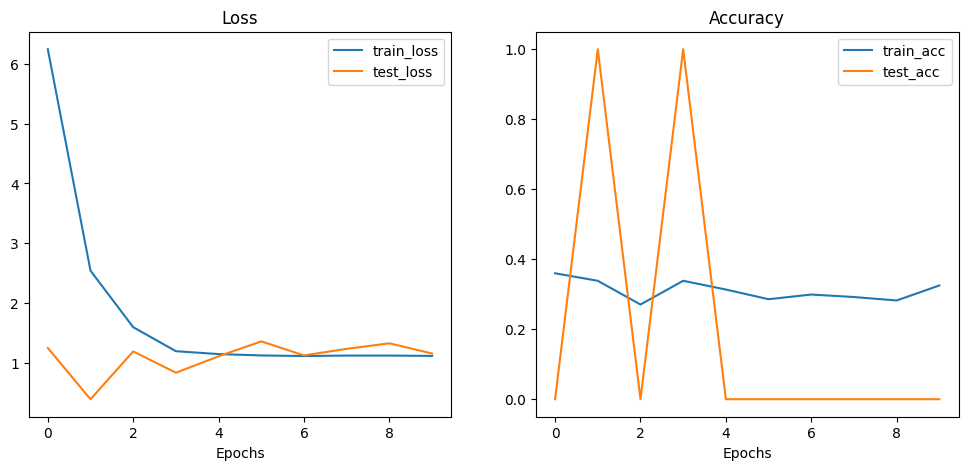

In [ ]:

# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

# Predictions

In [ ]:
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

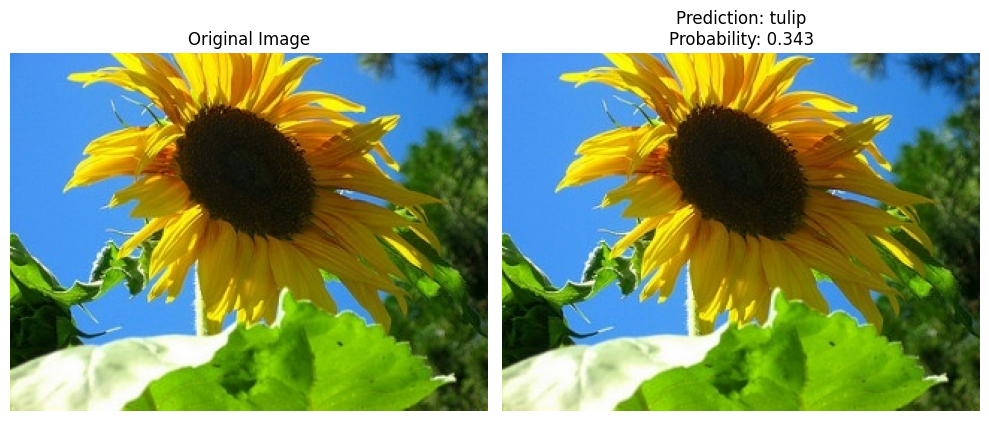

Predicted: tulip with 0.343 confidence


In [ ]:
import requests

# Setup custom image path
custom_image_path = "test_img.jpg"

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)